In [1]:
using DrWatson
@quickactivate "TriangularHubbard"

using DataStructures
using CodecXz
using SQLite
using DBInterface
using DataFrames
using Printf
using LsqFit
using ProgressMeter
using Quadmath
using Statistics
using ProgressMeter
using JSON
using LinearAlgebra

using PyPlot
using PyCall
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

  Activating project at `/data/pn1_1/klee/Projects/TriangularHubbard`


PyObject <module 'seaborn' from '/home/klee/.pyenv/versions/conda_jl/lib/python3.7/site-packages/seaborn/__init__.py'>

In [2]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [3]:
n_sites = 9
shape_str = "(3,0)x(0,3)"
t = 1.0
U = 20.0

20.0

In [4]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end
shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end
phases = cis.(-2π * momentums' * sitecoordinates)
;

In [5]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, (n_sites, 1))
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

In [6]:
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
isfile(sectors_filepath)

true

In [9]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df1 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 0 as sparsetype
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
# df2 = DataFrame(
#     DBInterface.execute(conn, """
#         SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 1 as sparsetype
#         FROM sparse_results_collection
#         INNER JOIN sectors
#         ON sparse_results_collection.idx = sectors.idx
#         WHERE hopping=? AND interaction=?
#     """, (t, U))
# )
DBInterface.close!(conn)

In [10]:
# df = vcat(df1, df2)
df = df1
;

In [11]:
names(df)

9-element Vector{String}:
 "nup"
 "ndn"
 "dim"
 "temperature"
 "partition"
 "spin_correlation"
 "energy"
 "energy_squared"
 "sparsetype"

In [12]:
df[:, :Sz] = 0.5*(df[:, :nup] - df[:, :ndn])
df[:, :charge] = df[:, :nup] + df[:, :ndn]
unique(sort(df[:, :Sz]))
# n_list = unique(df[:, :nup] .+ df[:, :ndn])
n_list = n_sites+4:-1:n_sites-5
temperatures = unique(sort(df[:, :temperature]))
;

In [13]:
conv(x::AbstractArray) = conv.(x)
function conv(x::AbstractDict)
    if keys(x) == Set(["re", "im"])
        r = conv(x["re"])
        i = conv(x["im"])
        r = isnothing(r) ? NaN : r
        i = isnothing(i) ? NaN : i
        return complex(r, i)
    else
        return Dict(k => conv(v) for (k, v) in x)
    end
end
conv(x::Number) = x
conv(x::AbstractString) = x
conv(x::Nothing) = NaN

conv (generic function with 5 methods)

In [14]:
szsz = []
for (irow, row) in enumerate(eachrow(df))
    push!(szsz, conv(JSON.parse(row[:spin_correlation])))
end
df[!, :SzSz] = real.(szsz)
;

In [15]:
temperatures = temperatures[0.1 .<= temperatures];

In [16]:
# Plot q=0 susceptibility

fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0
yoffsets = [15 * (length(n_list) - idx) for idx in 1:length(n_list)]
yoffsets[1:end-1] .+= 20
yoffsets[1:end-2] .+= 10

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    ys = 1 ./ ys
    yoffset = yoffsets[idx]

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx] + yoffset
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
    end
    ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
ax.set_ylim(-10, 280)

ax.legend(title=raw"$n=$", ncol=2, loc=4, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$1/\chi_{zz}$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/klee/.julia/packages/PyCall/BD546/src/numpy.jl:67


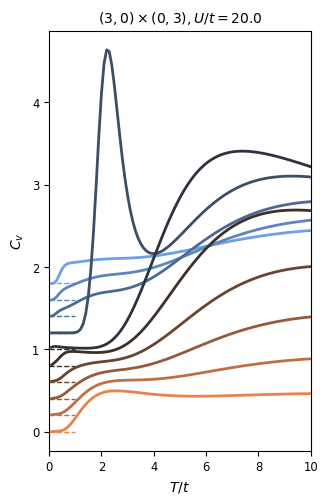

PyObject Text(0.5, 1.0, '$(3,0)\\times(0,3), U/t=20.0$')

In [17]:
# Plot Specific Heat

fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0
yoffsets = [0.2 * (length(n_list) - idx) for idx in 1:length(n_list)]
# yoffsets[1:end-1] .+= 20
# yoffsets[1:end-2] .+= 10

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :charge] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = sum(ssdf[:, :energy_squared]) / sum(ssdf[:, :partition])
        avg = sum(ssdf[:, :energy]) / sum(ssdf[:, :partition])
        if !isnan(corr)
            push!(xs, T)
            push!(ys, (corr - avg^2) / (n_sites * T))
        end
    end
    yoffset = yoffsets[idx]
    ys = ys .+ yoffset
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
        label="n=$(n/n_sites)"
    )
        ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)

end
ax.set_xlim(0, maximum(temperatures))
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$C_v$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


In [18]:
for f in df[:, :SzSz]
    @show phases * getrealspacemap(f)
    break
end

phases * getrealspacemap(f) = ComplexF64[0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im; 0.0 + 0.0im;;]


In [19]:
display

display (generic function with 30 methods)

In [20]:
df_sel = unique(df[(df[!, :spin_correlation] .== "[0.0,0.0,0.0,0.0]") .& (df[!, :temperature] .>= 0.3), [:nup, :ndn, :dim, :spin_correlation, :temperature, :partition]])

0×6 DataFrame

In [234]:
CSV.write("foo.csv", df_sel)

"foo.csv"

In [35]:
# Plot Susceptibility

fig = PyPlot.figure(figsize=(7, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)

ax = fig.add_subplot(1,2,1)

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :charge] .== n, :]
    for T in temperatures
        if !(0.3 <= T <= 10)
            continue
        end
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = sum(ssdf[:, :SzSz]) / sum(ssdf[:, :partition])
        corr = getrealspacemap(corr)
        corr = real.(phases * corr)
        y = 1 / (corr[1] ./ T)
#         y = sum(corr) / T 
        if y > 1E3
            continue
        end
        push!(xs, T)
        push!(ys, y)
    end

#     @show xs, ys
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
        label="n=$(n/n_sites)",
    )
end
# ax.set_xlabel(raw"$T/t$")
# ax.set_ylabel(raw"$\chi_{zz}$")
# # ax.set_ylim(-0.002, 0.002)
# # ax.set_xlim(0, nothing)
# ax.set_xscale("log")

ax.set_ylim(-10, 100)
ax.set_xlim(0, 10)
# ax.set_ylim(-10, 280)
# ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")
ax.legend()




PyObject <matplotlib.legend.Legend object at 0x7f6d291347d0>

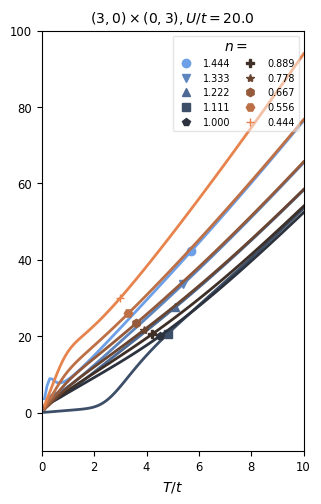

PyObject Text(0.5, 1.0, '$(3,0)\\times(0,3), U/t=20.0$')

In [33]:
# Plot q=0 susceptibility

fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :charge] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    ys = 1 ./ ys
    
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx]
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
    end
#     ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
# ax.set_ylim(0, 1)
ax.set_ylim(-10, 100)
# ax.set_ylim(0, 150)


ax.legend(title=raw"$n=$", ncol=2, loc=1, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T/t$")
# ax.set_ylabel(raw"$1/\chi_{zz}$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


In [238]:
fig = PyPlot.figure(figsize=(7, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)

ax = fig.add_subplot(1,2,1)

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = sum(ssdf[:, :energy_squared]) / sum(ssdf[:, :partition]) / (n_sites * T)
        Sz_avg = sum(ssdf[:, :energy]) / sum(ssdf[:, :partition])
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
        label="n=$(n/n_sites)",
    )
end
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$\chi_{zz}$")
# ax.set_ylim(-0.002, 0.002)
# ax.set_xlim(0, nothing)
# ax.set_xlim(0, 0.5)
# ax.set_ylim()
ax.set_ylim(-0.02, 0.005)
ax.set_xscale("log")
ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")
ax.legend()

PyObject <matplotlib.legend.Legend object at 0x7feee5bde990>

684956×11 DataFrame
    Row │ nup    ndn    temperature  partition  spin_correlation               ⋯
        │ Int64  Int64  Float64      Float64    String                         ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │     0      0         0.01     1.0     [0.0,0.0,0.0,0.0]              ⋯
      2 │     0      0         0.02     1.0     [0.0,0.0,0.0,0.0]
      3 │     0      0         0.03     1.0     [0.0,0.0,0.0,0.0]
      4 │     0      0         0.04     1.0     [0.0,0.0,0.0,0.0]
      5 │     0      0         0.05     1.0     [0.0,0.0,0.0,0.0]              ⋯
      6 │     0      0         0.06     1.0     [0.0,0.0,0.0,0.0]
      7 │     0      0         0.07     1.0     [0.0,0.0,0.0,0.0]
      8 │     0      0         0.08     1.0     [0.0,0.0,0.0,0.0]
      9 │     0      0         0.09     1.0     [0.0,0.0,0.0,0.0]              ⋯
     10 │     0      0         0.1      1.0     [0.0,0.0,0.0,0.0]
     11 │     0      0         0.2      1.0     [0.0,0.0,0.0,0.0]
   ⋮    │   ⋮      ⋮         ⋮           ⋮                      ⋮              ⋱
 684947 │     7      7         9.1     22.2348  [4.021713046933371,-0.37324492
 684948 │     7      7         9.2     23.6015  [4.258550951884088,-0.39509353 ⋯
 684949 │     7      7         9.3     25.027   [4.504859994178967,-0.41780883
 684950 │     7      7         9.4     26.5124  [4.7608139499046125,-0.4414065
 684951 │     7      7         9.5     28.0592  [5.026583477074494,-0.46590192
 684952 │     7      7         9.6     29.6685  [5.302336010385936,-0.49131018 ⋯
 684953 │     7      7         9.7     31.3416  [5.588235662882506,-0.51764608
 684954 │     7      7         9.8     33.0798  [5.884443134442332,-0.54492409
 684955 │     7      7         9.9     34.8842  [6.191115626998357,-0.57315837
 684956 │     7      7        10.0     36.756   [6.508406766383743,-0.60236276 ⋯
                                               7 columns and 684935 rows omitted

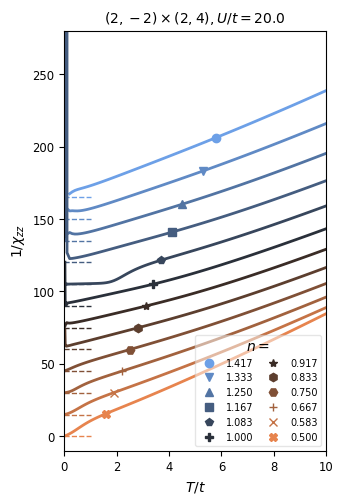

In [13]:
fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0
yoffsets = [15 * (length(n_list) - idx) for idx in 1:length(n_list)]
yoffsets[1:end-1] .+= 0
yoffsets[1:end-2] .+= 0

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    ys = 1 ./ ys
    yoffset = yoffsets[idx]

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx] + yoffset
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
    end
    ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
ax.set_ylim(-10, 280)

ax.legend(title=raw"$n=$", ncol=2, loc=4, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$1/\chi_{zz}$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

fig.savefig("triangular-hubbard-invsusc_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard-invsusc_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


In [15]:
@. model(x, p) = (x - p[2]) / p[1]
temperatures = unique(sort(df[:, :temperature]))
fit_temperatures = [T for T in temperatures if 0.7 <= T <= 5.5]

49-element Vector{Float64}:
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 ⋮
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0
 5.1
 5.2
 5.3
 5.4
 5.5

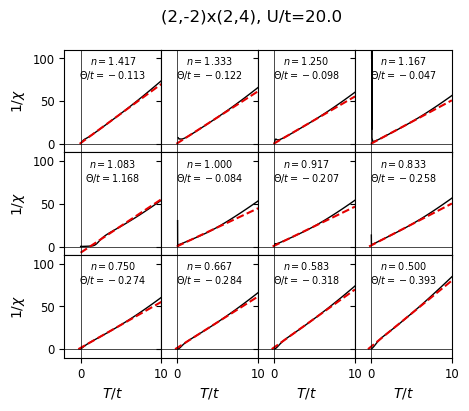

In [16]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (0.8 .<= xs .<= 5.5)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 110)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


In [21]:
fit_params = []
# for (idx, n) in enumerate(n_list)
for (idx, n) in enumerate(2:2*n_sites-2)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (0.8 .<= xs .<= 5.5)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)

2×21 Matrix{Float64}:
  2.0       3.0      4.0        5.0       …  21.0          22.0
 -4.88996  -1.2294  -0.750094  -0.523503      0.000669563   0.00458997

In [27]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-" , color="black", linewidth=0.5)
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_xlim(0.4, 1.6)
ymin = -1.6
ymax = 1.0
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$U/t=$(U/t)\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
fig.savefig("weisstemp-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
fig.savefig("weisstemp-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


In [ ]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (5 .<= xs)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 120)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


In [ ]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-")
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$t=1, U=20\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


## Plot Charge

In [277]:
# Plot Charge susceptibility
sdf = df
chemical_potentials = -20:0.1:40
Qg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
χg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
Tg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
μg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
@showprogress for (imu, mu) in enumerate(chemical_potentials)
    for (iT, T) in enumerate(temperatures)
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        z_ = Float128.(ssdf[:, :partition])
        q_ = Float128.(ssdf[:, :charge])
        T_ = Float128(T)
        mu_ = Float128(mu)
        emu_ = exp.(mu_ .* q_ / T_)
        qavg_ = sum(q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        q2avg_ = sum( q_ .* q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        Qg[iT, imu] = qavg_
        χg[iT, imu] = (q2avg_ - qavg_.^2) ./ (n_sites * T_)
        Tg[iT, imu] = T
        μg[iT, imu] = mu
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:55


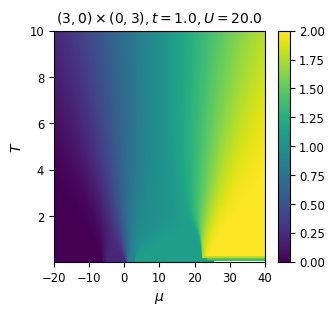

In [333]:
fig = PyPlot.figure(figsize=(3.4, 3))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, Qg ./ n_sites, vmin=0, vmax=2)
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

fig.colorbar(mappable=img)
# fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")


In [281]:
χg[isnan.(χg)] .= 0
χg[abs.(χg) .< 1E-8] .= 0
;

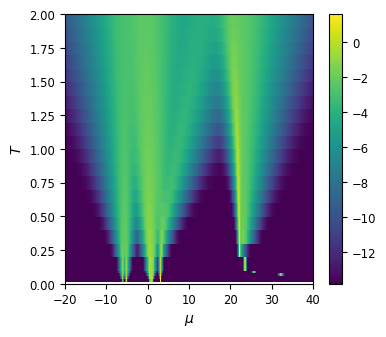

(0.0, 2.0)

In [282]:
fig = PyPlot.figure(figsize=(4, 3.5))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, log.(χg .+ 1E-6))
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
fig.colorbar(mappable=img)
ax.set_ylim(0, 2)

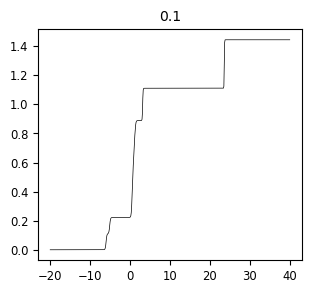

PyObject Text(0.5, 1.0, '0.1')

In [341]:
# for i in 1:size(μg, 1)
fig = PyPlot.figure(figsize=(3.4, 3))
let i = 5
    PyPlot.plot(μg[i, :], Qg[i, :] ./ n_sites, linewidth=0.5, color="black")
    PyPlot.title("$(Tg[i, 1])")
end

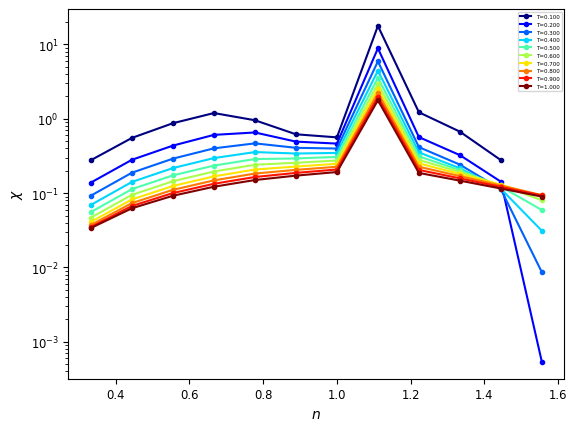